# Fake news exploration

Data downloaded from https://www.kaggle.com/c/fake-news/data.

Proposed process:

* Use pre-trained word embeddings
    * [SpaCy](https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/) - spacy has models included, so will start here. File is only 50MB which is much smaller than other options. spacy likely easier to load straight from python
    * [Stanford GlOve](https://nlp.stanford.edu/projects/glove/) - 882MB file, 
    * [Google news embeddings](https://code.google.com/archive/p/word2vec/) - suspect this might be best but is a 1.3GB file
* Train model on the embeddings
    * [keras](https://keras.io/examples/nlp/pretrained_word_embeddings/)
    * [xgboost](https://github.com/shangjingbo1226/fnc-1/blob/master/src/main.py)

In [23]:
import pandas as pd
import spacy
import numpy as np
from tensorflow import keras
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score, plot_precision_recall_curve

In [2]:
nlp = spacy.load("en_core_web_md")

In [3]:
df = pd.read_csv("fake_news/data/train.csv")

In [42]:
df["all_text"] = (df.title + " " + df.text).values

In [43]:
df = df[pd.notnull(df.all_text)]

In [34]:
print(df.label.value_counts())
print(df.shape)

1    10413
0    10387
Name: label, dtype: int64
(20800, 5)


In [18]:
doc = nlp("Test the processing of some text with spacy crev")

print(doc[3].vector)

print(doc.vector)

[ 6.0216e-02  2.1799e-01 -4.2490e-02 -3.8618e-01 -1.5388e-01  3.4635e-02
  2.2243e-01  2.1718e-01  6.8483e-03  2.4375e+00 -2.7418e-01  1.3572e-01
  3.1086e-01 -6.3206e-02  3.8225e-04 -1.8597e-01 -1.9333e-01  1.4447e+00
 -3.8541e-01 -2.8549e-01  7.5627e-02 -3.6799e-02 -4.6068e-01 -1.6835e-02
  1.9821e-01 -9.2746e-02  1.8954e-01 -3.2648e-04 -1.7081e-01  5.0359e-01
  4.6256e-01  2.6901e-01 -1.2256e-01  2.4713e-01  6.9305e-02 -2.0777e-01
 -4.4560e-01  3.0223e-01 -9.8344e-03  3.2772e-01  1.1038e-01  4.1271e-01
 -1.5854e-01 -5.6983e-02  3.8918e-01 -2.1158e-01 -1.3307e-01  4.0406e-01
  1.7490e-01  5.3949e-02  1.0984e-01 -1.8476e-01 -5.4014e-02  4.0112e-02
 -1.0175e-01  1.2662e-01  6.9709e-02 -2.4071e-01 -2.0995e-01 -5.1381e-02
  2.8219e-01  1.8598e-01 -5.0180e-01  2.7572e-01 -1.8497e-01 -1.8399e-01
  1.5696e-01 -3.8444e-02 -5.2238e-01  2.2753e-01  4.8672e-02 -7.8837e-02
  6.5448e-02  1.8399e-01  4.0211e-01 -1.2745e-01 -1.2302e-01  3.1072e-01
  9.9588e-02  3.6047e-02 -2.5946e-01  3.6128e-01  1

In [4]:
X_train = np.zeros((len(df), 300))

for index, sentence in enumerate(df.text.values):
    doc = nlp(sentence)
    X_train[index, :] = doc.vector

TypeError: object of type 'float' has no len()

In [5]:
y_train = df.label

In [19]:
rand_preds = np.random.randint(2, size=y_train.shape[0])

confusion_matrix(y_train, rand_preds)

array([[5197, 5190],
       [5142, 5271]])

In [22]:
average_precision_score(y_train, rand_preds)

0.5022683709472158

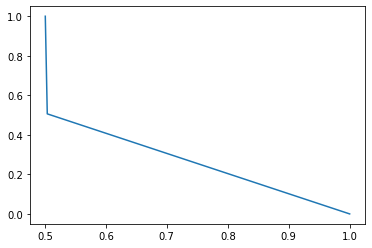

In [27]:
precision, recall, thresholds = precision_recall_curve(y_train, rand_preds)

plt.plot(precision, recall)
plt.show()

## Xgboost

In [7]:
dtrain = xgb.DMatrix(X_train, y_train)

In [10]:
param = {"max_depth":10, "eta":1, "objective":"binary:logistic"}
num_round = 10

In [11]:
xgb.cv(param, dtrain, num_round, nfold=5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.495601,0.001070,0.501923,0.005668
1,0.495276,0.001123,0.501731,0.005788
2,0.495204,0.001115,0.501538,0.005960
3,0.495204,0.001115,0.501635,0.005865
4,0.495204,0.001115,0.501250,0.005667
5,0.495204,0.001115,0.501346,0.005579
6,0.495204,0.001115,0.501298,0.005558
7,0.495204,0.001115,0.501394,0.005756
8,0.495204,0.001115,0.501394,0.005788
9,0.495204,0.001115,0.501154,0.005788


In [29]:
import optuna
import xgboost


class ObjectiveXgb:
    def __init__(self, data, labels, params, boost_rounds):
        self.data = xgboost.DMatrix(data, label=labels)
        self.params = params
        self.boost_rounds = boost_rounds

    def __call__(self, trial):
        # set fixed params
        trial_params = {
            "objective": "binary:logistic",
            "eval_metric": "aucpr",
        }

        # check variable params against input
        if "max_depth" in self.params:
            trial_params["max_depth"] = trial.suggest_int("max_depth", 1, 9)

        if "eta" in self.params:
            trial_params["eta"] = trial.suggest_loguniform("eta", 1e-3, 1.0)

        if "min_child_weight" in self.params:
            trial_params["min_child_weight"] = trial.suggest_int(
                "min_child_weight", 1, 9
            )
        if "gamma" in self.params:
            trial_params["gamma"] = trial.suggest_loguniform("gamma", 1e-3, 1.0)
        if "subsample" in self.params:
            trial_params["subsample"] = trial.suggest_loguniform(
                "subsample", 0.6, 1.0
            )
        if "colsample_bytree" in self.params:
            trial_params["colsample_bytree"] = trial.suggest_loguniform(
                "colsample_bytree", 0.6, 1.0
            )
        if "alpha" in self.params:
            trial_params["alpha"] = trial.suggest_loguniform("alpha", 1e-3, 1.0)
        if "lambda" in self.params:
            trial_params["lambda"] = trial.suggest_loguniform(
                "lambda", 1e-3, 1.0
            )

        pruning_callback = optuna.integration.XGBoostPruningCallback(
            trial, "test-aucpr"
        )

        scores = xgboost.cv(
            trial_params,
            self.data,
            num_boost_round=self.boost_rounds,
            callbacks=[pruning_callback],
        )
        return scores["test-aucpr-mean"].tail(1).values[0]


params = [
    "max_depth",
    "eta",
    "min_child_weight",
    "gamma",
    "subsample",
    "colsample_bytree",
    "alpha",
    "lambda",
]
study = optuna.create_study(direction="maximize")
study.optimize(ObjectiveXgb(X_train, y_train, params, 10), n_trials=10)
print(study.best_params)

[I 2020-11-24 10:41:31,095] A new study created in memory with name: no-name-f9850035-ed05-4ce2-999d-c8c8bb0fc9fe
[I 2020-11-24 10:41:32,848] Trial 0 finished with value: 0.504427 and parameters: {'max_depth': 2, 'eta': 0.8781646614071814, 'min_child_weight': 9, 'gamma': 0.00820256258485517, 'subsample': 0.8791007137841875, 'colsample_bytree': 0.6341375253293412, 'alpha': 0.4325044655701378, 'lambda': 0.003935604014540353}. Best is trial 0 with value: 0.504427.
[I 2020-11-24 10:41:34,682] Trial 1 finished with value: 0.5058226666666666 and parameters: {'max_depth': 3, 'eta': 0.04612618941519812, 'min_child_weight': 2, 'gamma': 0.02885211678824975, 'subsample': 0.733994789398677, 'colsample_bytree': 0.9200978137126534, 'alpha': 0.028263227015199597, 'lambda': 0.07222630363558077}. Best is trial 1 with value: 0.5058226666666666.
[I 2020-11-24 10:41:36,586] Trial 2 finished with value: 0.5051783333333333 and parameters: {'max_depth': 7, 'eta': 0.0030433168299105816, 'min_child_weight': 2,

{'max_depth': 3, 'eta': 0.04612618941519812, 'min_child_weight': 2, 'gamma': 0.02885211678824975, 'subsample': 0.733994789398677, 'colsample_bytree': 0.9200978137126534, 'alpha': 0.028263227015199597, 'lambda': 0.07222630363558077}


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
vec = TfidfVectorizer(max_features=10000)
X = vec.fit_transform(df.all_text)

In [47]:
X.shape

(20203, 10000)

In [48]:
study = optuna.create_study(direction="maximize")
study.optimize(ObjectiveXgb(X, df.label, params, 10), n_trials=10)
print(study.best_params)

[I 2020-11-24 13:37:29,206] A new study created in memory with name: no-name-aeb3a3f7-b5ae-4ee2-b491-b832298b5738
[I 2020-11-24 13:37:36,368] Trial 0 finished with value: 0.984126 and parameters: {'max_depth': 7, 'eta': 0.0010570306934632135, 'min_child_weight': 5, 'gamma': 0.11069397277450063, 'subsample': 0.7224543850464474, 'colsample_bytree': 0.6405886830791608, 'alpha': 0.1805579948346299, 'lambda': 0.3334680708428777}. Best is trial 0 with value: 0.984126.
[I 2020-11-24 13:37:44,984] Trial 1 finished with value: 0.9823213333333333 and parameters: {'max_depth': 9, 'eta': 0.0014049400970806813, 'min_child_weight': 5, 'gamma': 0.008907585794928733, 'subsample': 0.853254024599558, 'colsample_bytree': 0.8137064988929391, 'alpha': 0.3900256870686083, 'lambda': 0.856473939423918}. Best is trial 0 with value: 0.984126.
[I 2020-11-24 13:37:52,858] Trial 2 finished with value: 0.9869163333333333 and parameters: {'max_depth': 8, 'eta': 0.023417295129674713, 'min_child_weight': 6, 'gamma': 0

{'max_depth': 8, 'eta': 0.023417295129674713, 'min_child_weight': 6, 'gamma': 0.00616645159648425, 'subsample': 0.8712535166224095, 'colsample_bytree': 0.6120602654415218, 'alpha': 0.00102362607551017, 'lambda': 0.005267084500654618}


In [65]:
from sklearn.model_selection import train_test_split

parameters = {
    "max_depth": 8,
    "eta": 0.023417295129674713,
    "min_child_weight": 6,
    "gamma": 0.00616645159648425,
    "subsample": 0.8712535166224095,
    "colsample_bytree": 0.6120602654415218,
    "alpha": 0.00102362607551017,
    "lambda": 0.005267084500654618,
}

X_train, X_test, y_train, y_test = train_test_split(
    X, df.label, test_size=0.25, random_state=42
)


print(X_train.shape)
print(y_train.shape)

train_data = xgb.DMatrix(X_train, y_train)
test_data = xgb.DMatrix(X_test, y_test)


bst = xgb.train(parameters, test_data, 10)

(15152, 10000)
(15152,)


In [67]:
y_pred = bst.predict(test_data)>0.5

In [69]:
confusion_matrix(y_test, y_pred)

array([[2553,   75],
       [  27, 2396]])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

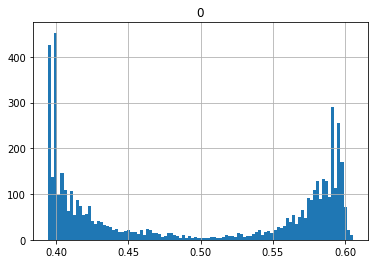

In [74]:
pd.DataFrame(bst.predict(test_data)).hist(bins=100)

## Tensorflow

In [42]:
embedding_layer = layers.Embedding(
    20800,
    300,
    embeddings_initializer = keras.initializers.Constant(X_train),
    trainable=False,
)

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="float64")

embedded_sequences = embedding_layer
x = layers.Embedding()